# Tutorial 1: Constructing a Bank

This tutorial demonstrates how to construct a waveform bank using a power-law prior. We'll show two approaches:
1. **Step 1**: Using `dot_pe` methods (streamlined approach)
2. **Step 2**: Using `PowerLawIntrinsicIASPrior` directly and transparently (shows what's happening under the hood)

The bank will use the `IMRPhenomXPHM` approximant and include importance sampling weights.


Import required libraries and set up the output directory for the bank.

In [1]:
import sys

sys.path.append("../..")
import pandas as pd
from pathlib import Path
import warnings
import numpy as np

warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

from cogwheel import gw_utils, gw_plotting, utils
from dot_pe import waveform_banks, config
from dot_pe.power_law_mass_prior import PowerLawIntrinsicIASPrior

# Set up artifacts directory for all outputs
ARTIFACTS_DIR = Path("./artifacts")
ARTIFACTS_DIR.mkdir(exist_ok=True)


/Users/jonatahm/Work/GW/dot-pe-future/notebooks/01_construct_bank/../../dot_pe/power_law_mass_prior.py:27: SyntaxWarning: invalid escape sequence '\p'
  Power-law prior for detector-frame chirp mass: P(M_c) \propto M_c^{-1.7}


In [ ]:
# Set up output directory
bank_dir = ARTIFACTS_DIR / "bank"
bank_dir.mkdir(parents=True, exist_ok=True)
bank_config_path = bank_dir / "bank_config.json"
waveforms_dir = bank_dir / "waveforms"

## Step 1: Using PowerLawIntrinsicIASPrior Directly

First, we'll use the power-law prior directly to generate samples. This approach is transparent and shows exactly what's happening.


In [3]:
# Bank configuration parameters
bank_size = 2**14  # Small bank for tutorial
mchirp_min = 5.0
mchirp_max = 20.0
q_min = 0.2
f_ref = 50.0
seed = 1701
n_pool = 4  # Number of parallel processes for waveform generation
blocksize = 4096
approximant = "IMRPhenomXPHM"

print(f"Bank size: {bank_size:,}")
print(f"Chirp mass range: [{mchirp_min}, {mchirp_max}]")
print(f"q_min: {q_min}")
print(f"f_ref: {f_ref}")
print(f"Number of cores (n_pool): {n_pool}")
print(f"Approximant: {approximant}")
print(f"Seed: {seed}")


Bank size: 16,384
Chirp mass range: [5.0, 20.0]
q_min: 0.2
f_ref: 50.0
Number of cores (n_pool): 4
Approximant: IMRPhenomXPHM
Seed: 1701


Create a corner plot to visualize the 9 sampled parameters from the bank.


In [4]:
# Use dot_pe to create bank using power-law prior
from dot_pe.sample_banks import main

print(f"Creating bank using dot_pe methods...")
main(
    bank_size=bank_size,
    q_min=q_min,
    m_min=mchirp_min,
    m_max=mchirp_max,
    f_ref=f_ref,
    fbin=config.DEFAULT_FBIN,
    n_pool=n_pool,
    blocksize=blocksize,
    bank_dir=str(bank_dir),
    seed=seed,
    approximant=approximant,
    inc_faceon_factor=None,
)

print(f"Bank created in: {bank_dir}")

# Load the created bank
samples_path = bank_dir / "intrinsic_sample_bank.feather"
bank_df = pd.read_feather(samples_path)

print(f"Loaded {len(bank_df):,} samples")


2026-01-01 15:53:12,156 - INFO - dot_pe.waveform_banks started at Thu Jan  1 15:53:12 2026


Creating bank using dot_pe methods...
Generating intrinsic samples
Saved intrinsic samples to artifacts/01_construct_bank/bank/intrinsic_sample_bank.feather
Auto-detected 4 missing blocks: [0, 1, 2, 3]
Creating waveforms


2026-01-01 15:53:22,850 - INFO - dot_pe.waveform_banks finished after 10.7 seconds (0.178 minutes).


waveform bank created at artifacts/01_construct_bank/bank/waveforms
Bank created in: artifacts/01_construct_bank/bank
Loaded 16,384 samples


### Compute Derived Quantities and Importance Weights

We need to compute derived quantities (mchirp, lnq, chieff) and **manually add** the importance sampling weights. The weights are required for proper importance sampling and are not computed automatically.


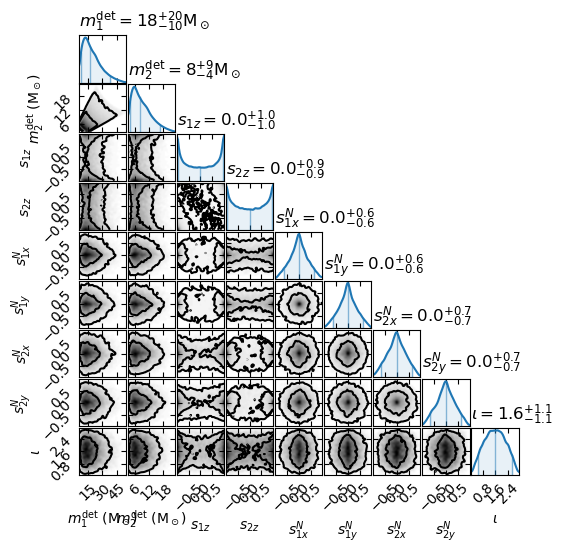

In [5]:
# Parameters to plot (9 parameters, excluding log_prior_weights)
plot_params = ["m1", "m2", "s1z", "s2z", "s1x_n", "s1y_n", "s2x_n", "s2y_n", "iota"]

# Create CornerPlot using unweighted samples
corner_plot = gw_plotting.CornerPlot(
    bank_df,
    params=plot_params,
    smooth=1.0,
)

corner_plot.plot(max_figsize=6)


## Step 2: Using PowerLawIntrinsicIASPrior Directly

Now we'll show how to use the power-law prior directly to generate samples. This approach is transparent and shows exactly what's happening under the hood.


We assume the IAS chirp-mass prior $P(\mathcal{M}_c^{\rm det})={\rm const.}$, but we draw from $P'(\mathcal{M}_c^{\rm det})=(\mathcal{M}_c^{\rm det})^{-1.7}$. 

### Bank Configuration

Set up the bank parameters.


In [6]:
# Bank configuration parameters
powerlaw_bank_size = 2**16
powerlaw_mchirp_min = 5.0
powerlaw_mchirp_max = 20.0
powerlaw_q_min = 0.2
powerlaw_f_ref = 50.0
powerlaw_seed = 20251209

print(f"Bank size: {powerlaw_bank_size:,}")
print(f"Chirp mass range: [{powerlaw_mchirp_min}, {powerlaw_mchirp_max}]")
print(f"q_min: {powerlaw_q_min}")
print(f"f_ref: {powerlaw_f_ref}")
print(f"Seed: {powerlaw_seed}")


Bank size: 65,536
Chirp mass range: [5.0, 20.0]
q_min: 0.2
f_ref: 50.0
Seed: 20251209


In [7]:
### Generate Samples Using PowerLawIntrinsicIASPrior

# Initialize PowerLawIntrinsicIASPrior
powerlaw_prior = PowerLawIntrinsicIASPrior(
    mchirp_range=(powerlaw_mchirp_min, powerlaw_mchirp_max),
    q_min=powerlaw_q_min,
    f_ref=powerlaw_f_ref,
)

# Generate samples
print(f"Generating {powerlaw_bank_size:,} samples...")
powerlaw_samples = powerlaw_prior.generate_random_samples(
    powerlaw_bank_size, seed=powerlaw_seed, return_lnz=False
)
print(f"Generated {len(powerlaw_samples):,} samples")


Generating 65,536 samples...
Generated 65,536 samples


In [8]:
powerlaw_prior.inverse_transform_samples(powerlaw_samples)
powerlaw_samples["mchirp"] = gw_utils.m1m2_to_mchirp(
    powerlaw_samples["m1"], powerlaw_samples["m2"]
)

### Generate Waveforms

Now we'll generate waveforms using `dot_pe.waveform_banks.create_waveform_bank_from_samples`. This uses the `n_pool` parameter for parallel processing.


In [9]:
# Generate waveforms
print(f"Generating waveforms using {n_pool} cores...")
print(f"Waveform directory: {waveforms_dir}")

waveform_banks.create_waveform_bank_from_samples(
    samples_path=samples_path,
    bank_config_path=bank_config_path,
    waveform_dir=waveforms_dir,
    n_pool=n_pool,  # Number of parallel processes
    blocksize=blocksize,
    approximant=approximant,
)
print("Waveform generation complete!")


2026-01-01 15:53:31,686 - INFO - dot_pe.waveform_banks started at Thu Jan  1 15:53:31 2026
2026-01-01 15:53:31,686 - INFO - dot_pe.waveform_banks started at Thu Jan  1 15:53:31 2026


Generating waveforms using 4 cores...
Waveform directory: artifacts/01_construct_bank/bank/waveforms


2026-01-01 15:53:41,107 - INFO - dot_pe.waveform_banks finished after 9.42 seconds (0.157 minutes).
2026-01-01 15:53:41,107 - INFO - dot_pe.waveform_banks finished after 9.42 seconds (0.157 minutes).


Waveform generation complete!


### Visualize the Bank

Create a `MultiCornerPlot` showing the 9 sampled parameters, and the difference between the weighted and un-weighted samples.



In [10]:
powerlaw_samples.columns

Index(['mchirp_p', 'lnq', 'chieff', 'cumchidiff', 'costheta_jn', 'phi_jl_hat',
       'phi12', 'cums1r_s1z', 'cums2r_s2z', 'f_ref', 'm1', 'm2', 's1z', 's2z',
       'iota', 's1x_n', 's1y_n', 's2x_n', 's2y_n', 'l1', 'l2', 'mchirp'],
      dtype='object')

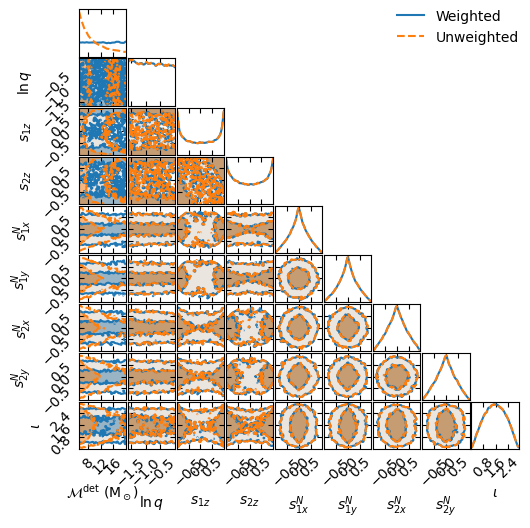

In [11]:
# Parameters to plot (9 parameters, excluding log_prior_weights)
plot_params = [
    "mchirp",
    "lnq",
    "s1z",
    "s2z",
    "s1x_n",
    "s1y_n",
    "s2x_n",
    "s2y_n",
    "iota",
]

# Create weighted and unweighted versions for comparison
powerlaw_samples["log_prior_weights"] = +1.7 * np.log(powerlaw_samples["mchirp"])
powerlaw_samples["weights"] = utils.exp_normalize(
    powerlaw_samples["log_prior_weights"].values
)

powerlaw_samples_unweighted = powerlaw_samples.copy()
powerlaw_samples_unweighted["weights"] = 1 / len(powerlaw_samples_unweighted)

# Create MultiCornerPlot comparing weighted vs unweighted
corner_plot = gw_plotting.MultiCornerPlot(
    [powerlaw_samples, powerlaw_samples_unweighted],
    params=plot_params,
    smooth=1.0,
    labels=["Weighted", "Unweighted"],
)

corner_plot.plot(max_figsize=6)


In [12]:
waveform_folder = Path("bank/waveforms/")
npy_files = sorted(list(waveform_folder.glob("*.npy")))
i, m, p, f = np.load(npy_files[0]).shape

print(f"Number of waveforms: {i}")
print(f"Number of modes: {m}")
print(f"Number of polarizations: {p}")
print(f"Number of frequencies (heterodyning): {f}")


IndexError: list index out of range